In [1]:
%matplotlib notebook

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
from sklearn.cluster import KMeans
import multiprocessing
from functools import partial
import time
import os
from os.path import join
import re

import wolff
import wolff_cross

# Track calculation errors
np.seterr('raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [2]:
start_path = '/Users/share/Chiel4Loran/testmodels'
pat_neuro = re.compile(r"neuro_mem")

neuro_prefix = "neuro_mem"
angle_prefix = "initial_angles"

files = []
params = []

for (dirpath, dirnames, filenames) in os.walk(start_path):
    neuro_files = list(filter(pat_neuro.match, filenames))
    _params = [pat_neuro.sub("", file) for file in neuro_files]
    files += [(join(dirpath, neuro_prefix+param), join(dirpath, angle_prefix+param)) for param in _params]
    params += _params
    
params = [re.sub(r"(^_)|(\.npy)", "", param) for param in params]
params_txt = [re.sub(r"_", " ", param) for param in params]
params_txt = [re.sub(r",", ".", param) for param in params_txt]

In [3]:
# Group the thousands of neurons into a handful of channels 
def group(mem_data):
    cut_data = mem_data[:, :500, :] # trials by 500 by neurons
    num_channels = 17
    neurons = np.mean(cut_data, 1).T # neurons by trials
    kmeans = KMeans(n_clusters=num_channels, n_init=20, n_jobs=10, tol=1e-20).fit(neurons)
    
    data = np.empty((mem_data.shape[0], num_channels, mem_data.shape[1])) # trials by num_channels by timesteps
    for channel in range(num_channels):
        print(str(channel + 1) + "/" + str(num_channels), end='\r')
        data[:, channel, :] = np.mean(mem_data[:, :, kmeans.labels_ == channel], axis=2)
    
    return data

In [4]:
paths_prepared = []

for (dat_file, ang_file), param in zip(files, params):
    print("Preparing for " + param)
    path = join('/Users/s3182541/STSP/Decoding/data/testmodels', param)
    paths_prepared.append(path)
    
    if not os.path.exists(path):
        # Load raw data and angles
        data_raw = np.load(dat_file)
        angles = np.load(ang_file)

        # Prepare data and transform angles
        data = group(data_raw)
        data += np.random.normal(scale=0.5, size=data.shape) # Prevent division by zero errors
        angles = angles / 360 * 2 * np.pi # Convert to radians
        angles = angles * 2 # 'Scale' angles

        if __name__ == '__main__':
            sigma = wolff_cross.prepare_sigma(data)

        # Save all of it to file
        if not os.path.exists(path):
            os.mkdir(path)

        np.save(join(path, "data.npy"), data)
        np.save(join(path, "angles.npy"), angles)
        np.save(join(path, "sigma.npy"), sigma)

Preparing for model2
Preparing for model5
Preparing for model4
Preparing for model3
Preparing for model7
Preparing for model6
Preparing for model1


In [5]:
files, params, params_txt, paths_prepared = zip(*sorted(zip(
    files, 
    params, 
    params_txt, 
    paths_prepared), key=lambda tup: tup[3]))

In [15]:
# Start four processes
# Define a function that:
#  uses a path to read in data 
#  starts the decoding
#  writes the result to disk

def decode_file(path_tup):
    i, path = path_tup
    
    print("Starting with " + path)
    
    if not os.path.exists(join(path, "c.npy")):
        data = np.load(join(path, "data.npy"))
        angles = np.load(join(path, "angles.npy"))
        sigma = np.load(join(path, "sigma.npy"))

        bin_width = np.pi / 6

#         device_i = i % 4
        device_i = 0
    
        cross_cos_amp = wolff_cross.cross_decode(data, angles, bin_width, sigma, device_i)
        c = np.mean(cross_cos_amp, 0)

        np.save(join(path, "c.npy"), c)
    
    print("Done with " + path)

if __name__ == '__main__':
    with multiprocessing.Pool(4) as pool:
        calcs = pool.imap(decode_file, enumerate(paths_prepared))
        for i, path in enumerate(paths_prepared):
            next(calcs)

Starting with /Users/s3182541/STSP/Decoding/data/testmodels/model2
Starting with /Users/s3182541/STSP/Decoding/data/testmodels/model4
Starting with /Users/s3182541/STSP/Decoding/data/testmodels/model3
Done with /Users/s3182541/STSP/Decoding/data/testmodels/model2
Done with /Users/s3182541/STSP/Decoding/data/testmodels/model3
Done with /Users/s3182541/STSP/Decoding/data/testmodels/model4
Starting with /Users/s3182541/STSP/Decoding/data/testmodels/model5
Starting with /Users/s3182541/STSP/Decoding/data/testmodels/model6
Starting with /Users/s3182541/STSP/Decoding/data/testmodels/model7
Starting with /Users/s3182541/STSP/Decoding/data/testmodels/model1
Done with /Users/s3182541/STSP/Decoding/data/testmodels/model1
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Trial 1/360
Trial 1/360
Trial 1/360
Trial 2/360
Trial 2/360
Trial 2/360
Trial 3/360
Trial 3/360
Trial 3/360


Trial 182/360
Trial 183/360
Trial 183/360
Trial 183/360
Trial 184/360
Trial 184/360
Trial 184/360
Trial 185/360
Trial 185/360
Trial 185/360
Trial 186/360
Trial 186/360
Trial 186/360
Trial 187/360
Trial 187/360
Trial 187/360
Trial 188/360
Trial 188/360
Trial 188/360
Trial 189/360
Trial 189/360
Trial 189/360
Trial 190/360
Trial 190/360
Trial 190/360
Trial 191/360
Trial 191/360
Trial 191/360
Trial 192/360
Trial 192/360
Trial 192/360
Trial 193/360
Trial 193/360
Trial 193/360
Trial 194/360
Trial 194/360
Trial 194/360
Trial 195/360
Trial 195/360
Trial 195/360
Trial 196/360
Trial 196/360
Trial 196/360
Trial 197/360
Trial 197/360
Trial 197/360
Trial 198/360
Trial 198/360
Trial 198/360
Trial 199/360
Trial 199/360
Trial 199/360
Trial 200/360
Trial 200/360
Trial 200/360
Trial 201/360
Trial 201/360
Trial 201/360
Trial 202/360
Trial 202/360
Trial 202/360
Trial 203/360
Trial 203/360
Trial 203/360
Trial 204/360
Trial 204/360
Trial 204/360
Trial 205/360
Trial 205/360
Trial 205/360
Trial 206/360
Trial 

In [6]:
params_txt = [
    "model 1: probe = 0.05, FF: 0.100*1,5, noiseSD = 0.01",
    "model 2: probe = 0,2, FF: 0.100*1.5, noiseSD = 0.01",
    "model 3: probe = 0.05, FF: 0.100*1.5, noiseSD = 0.01, rec=0.200*0.1",
    "model 4: probe = 0.05, FF: 0.100*1.5, noiseSD = 0.01, rec=0.200*0.3",
    "model 5: probe = 0.05, FF: 0.100*1.5, noiseSD = 0.01, rec=0.200*0.45",
    "model 6: probe = 0.05, FF: 0.100*1.5, noiseSD = 0.01, rec=0.200*0.60",
    "model 7: probe = 0.05, FF: 0.100*1.5, noiseSD = 0.01, rec=0.200*0.75"
]

<IPython.core.display.Javascript object>


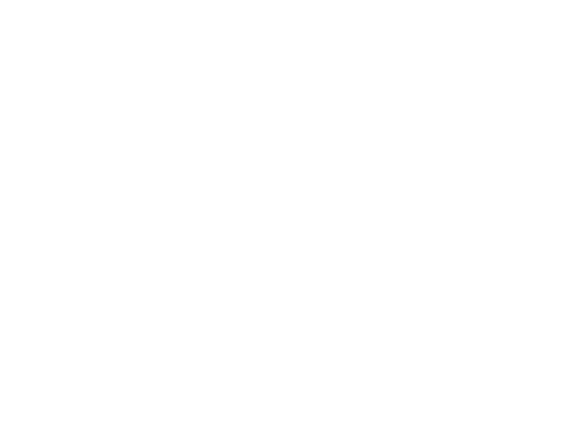

<IPython.core.display.Javascript object>


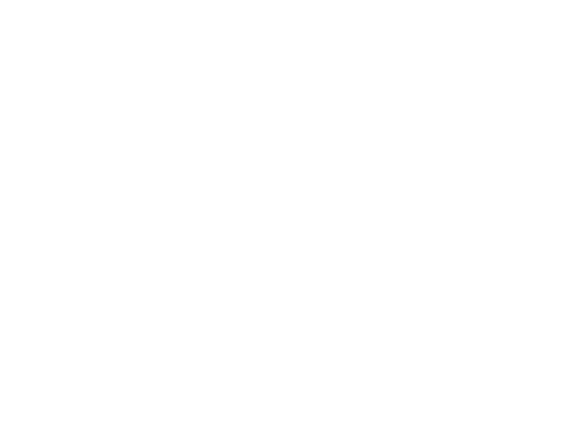

<IPython.core.display.Javascript object>


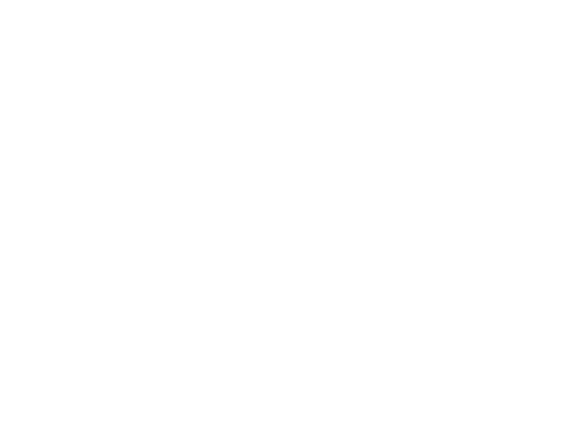

<IPython.core.display.Javascript object>


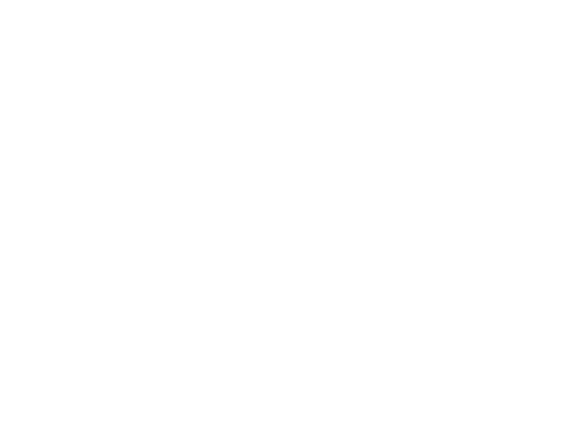

<IPython.core.display.Javascript object>


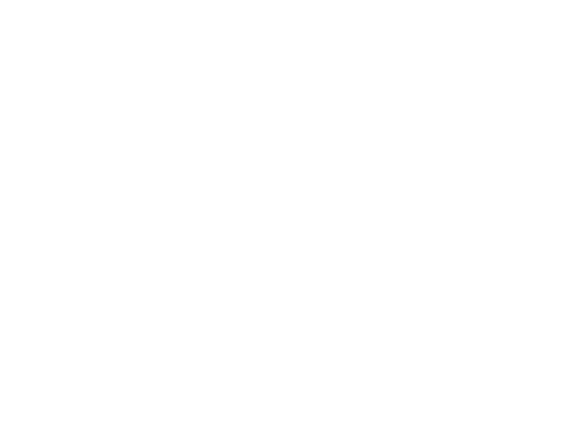

<IPython.core.display.Javascript object>


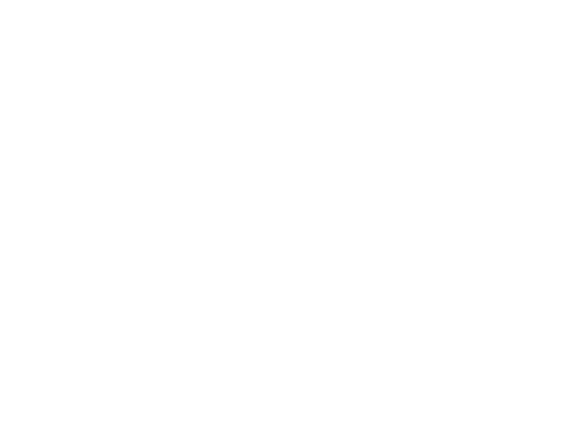

<IPython.core.display.Javascript object>


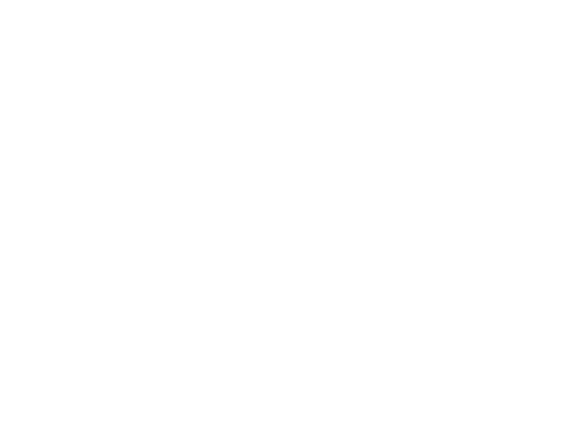

<IPython.core.display.Javascript object>


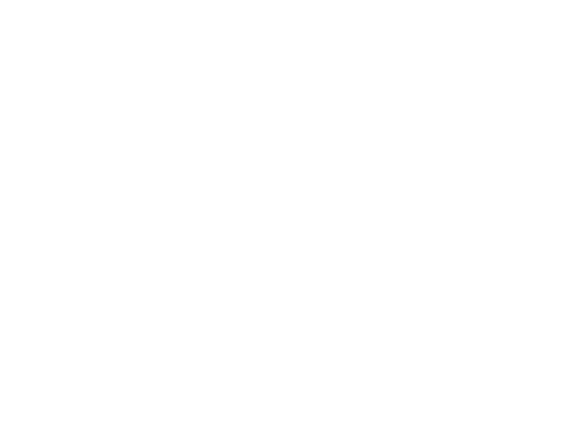

<IPython.core.display.Javascript object>


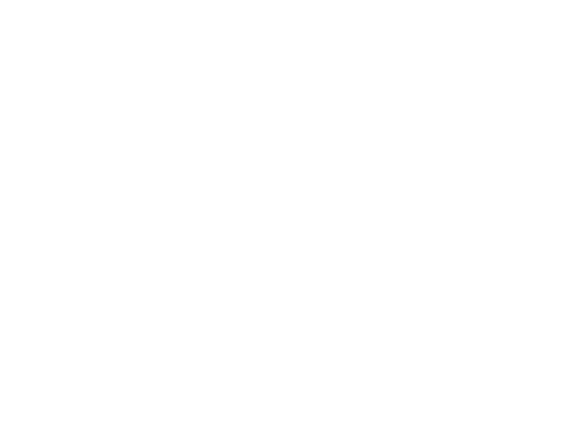

<IPython.core.display.Javascript object>


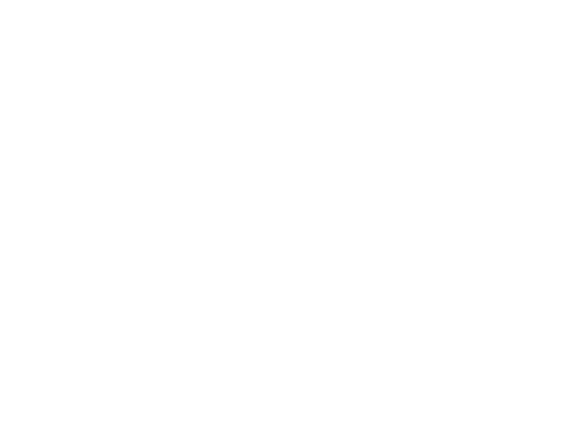

<IPython.core.display.Javascript object>


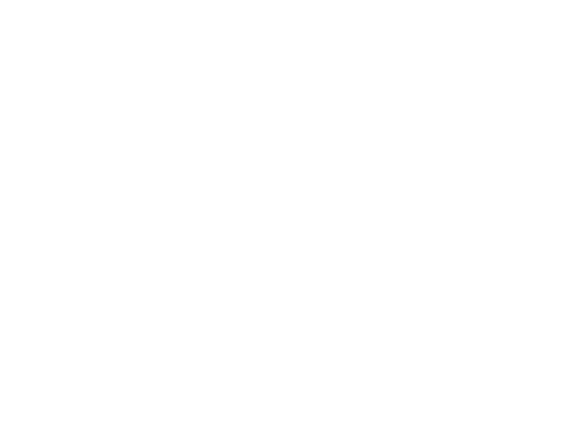

<IPython.core.display.Javascript object>


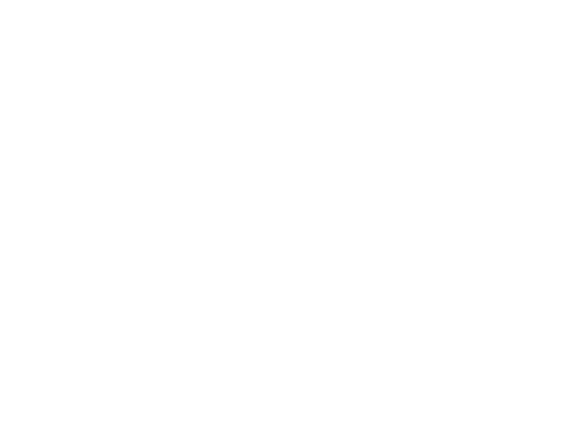

<IPython.core.display.Javascript object>


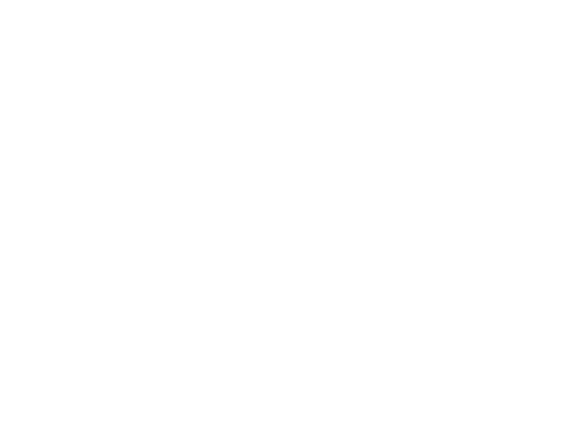

<IPython.core.display.Javascript object>


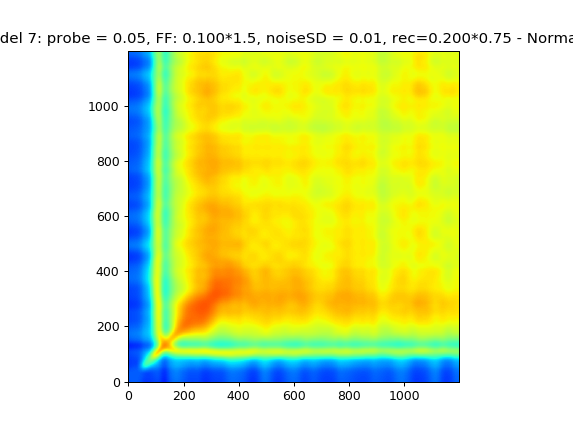

In [8]:
vmin = 0
vmax = 0

for path, param_txt in zip(paths_prepared, params_txt):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))
    
    plt.close()

    model_txt = param_txt.split(':')[0]
    save_path = join("/Users/s3182541/STSP/Decoding/data/testmodels/plots", model_txt)
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    plt.title(param_txt + " - Not normalised")
    plt.imshow(filtered, cmap='jet', origin='lower')
    plt.savefig(
        join(save_path, "not-normalised.pdf"), 
        dpi=300, 
        format='pdf')
    
for path, param_txt in zip(paths_prepared, params_txt):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    plt.close()

    plt.title(param_txt + " - Normalised")
    plt.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    plt.savefig(join(path, "normalised.pdf"), dpi=300, format='pdf')

<IPython.core.display.Javascript object>


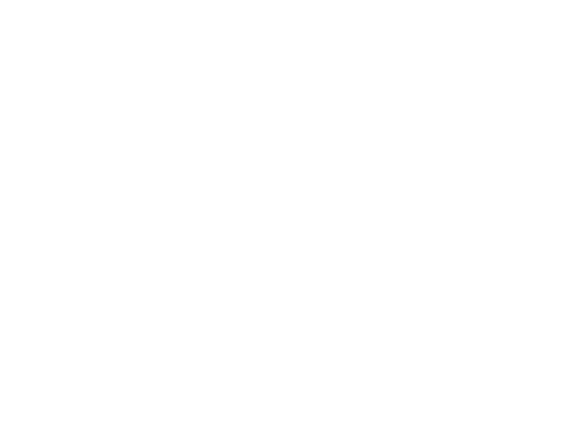

<IPython.core.display.Javascript object>


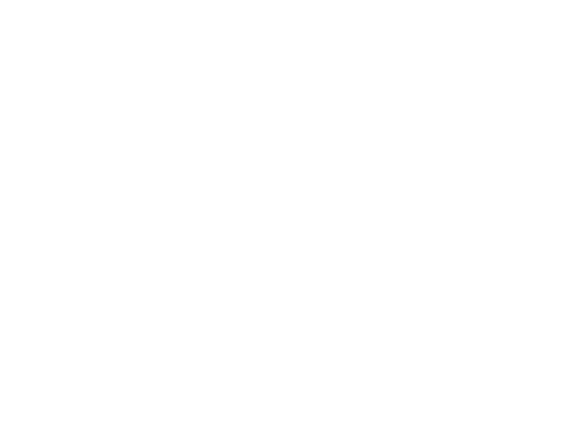

<IPython.core.display.Javascript object>


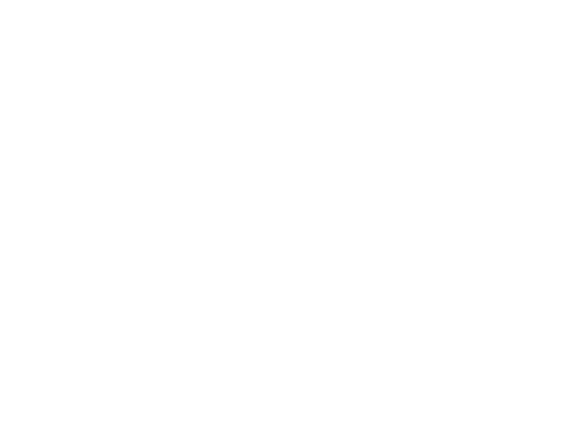

<IPython.core.display.Javascript object>


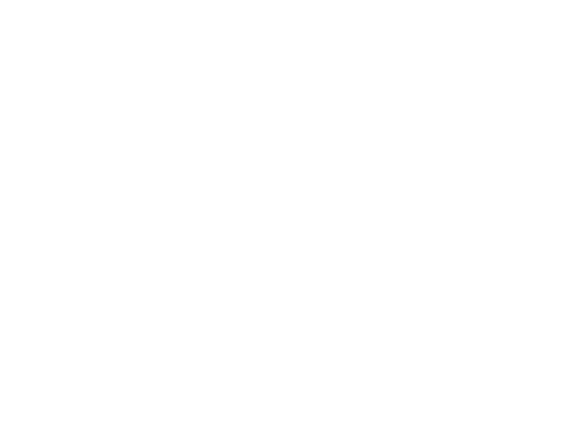

<IPython.core.display.Javascript object>


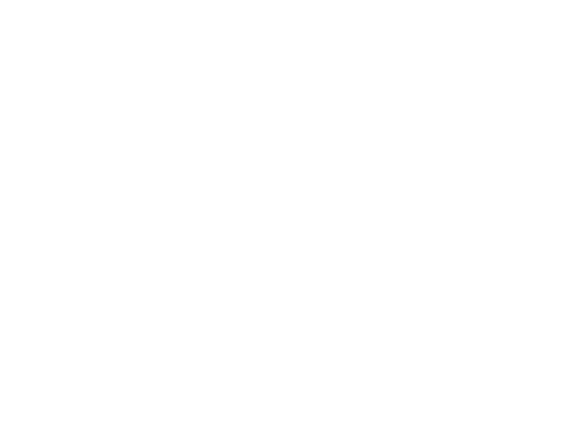

<IPython.core.display.Javascript object>


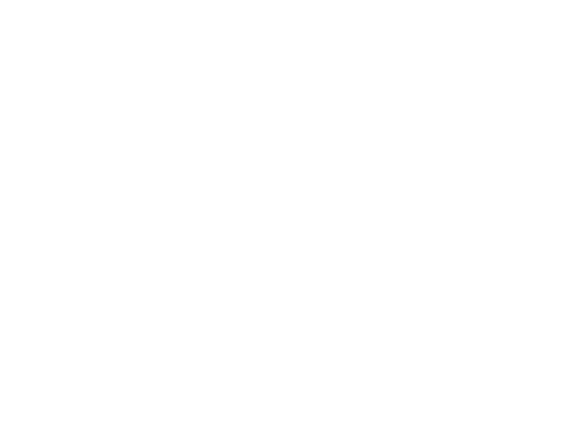

<IPython.core.display.Javascript object>


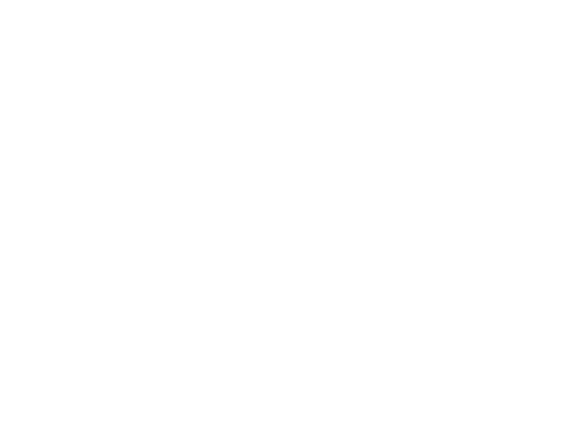

<IPython.core.display.Javascript object>


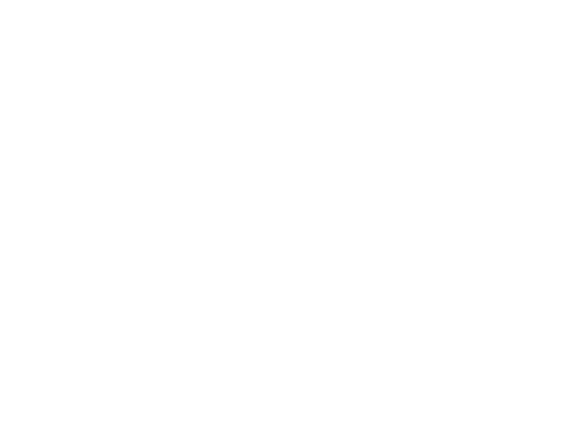

<IPython.core.display.Javascript object>


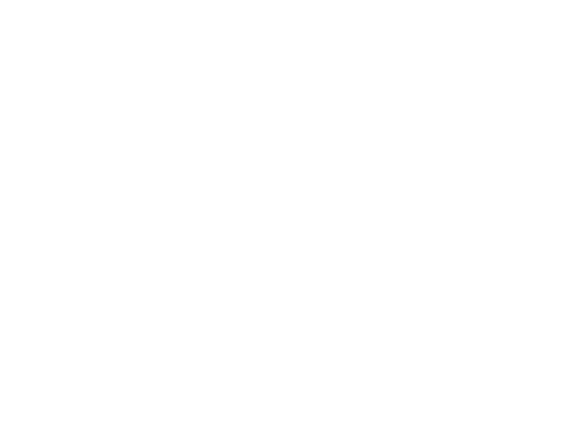

<IPython.core.display.Javascript object>


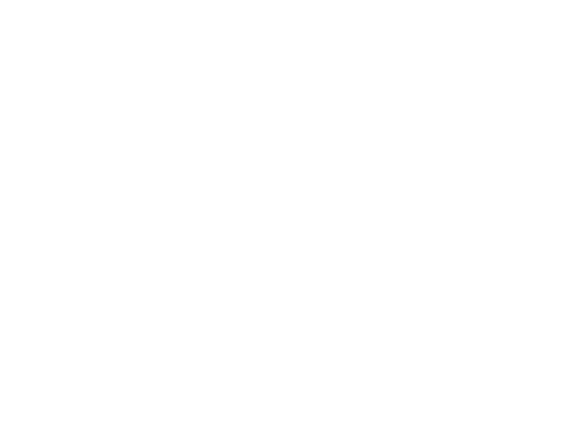

<IPython.core.display.Javascript object>


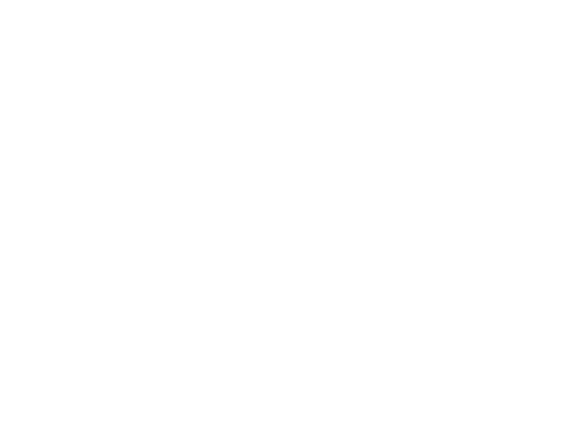

<IPython.core.display.Javascript object>


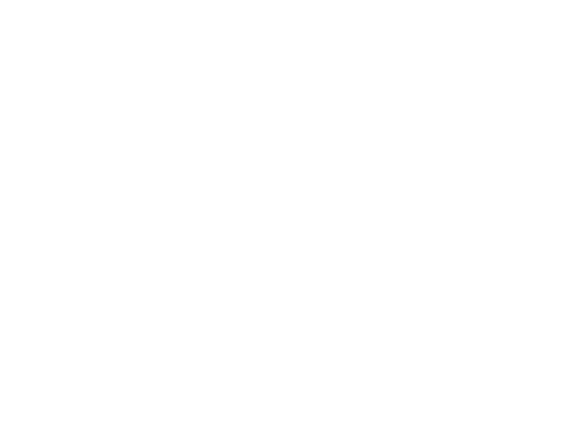

<IPython.core.display.Javascript object>


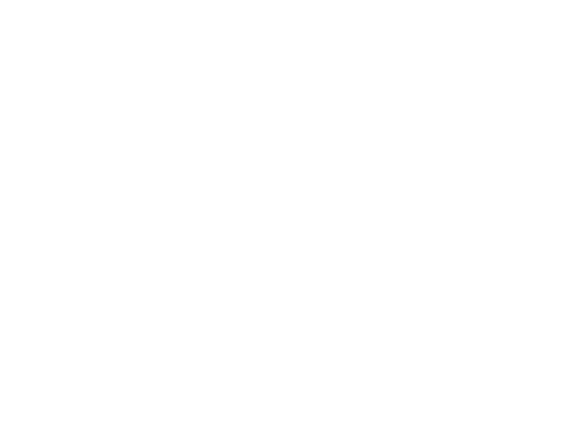

<IPython.core.display.Javascript object>


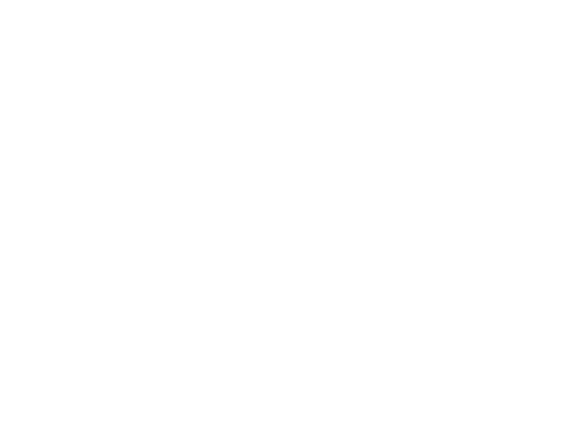

<IPython.core.display.Javascript object>


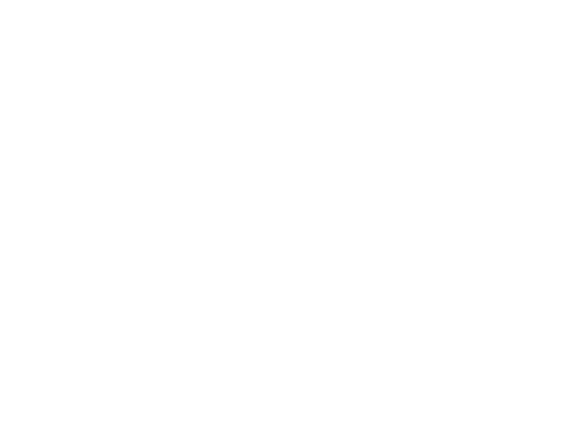

<IPython.core.display.Javascript object>


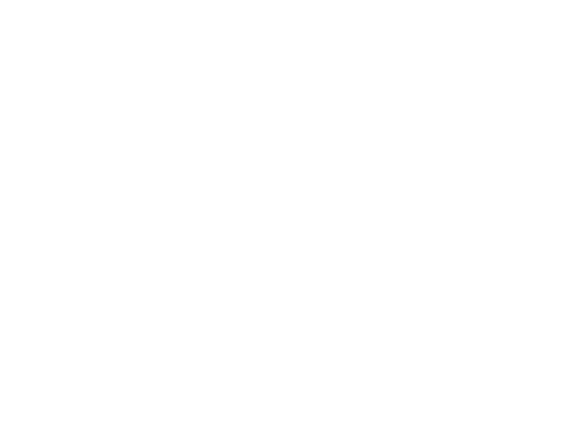

<IPython.core.display.Javascript object>


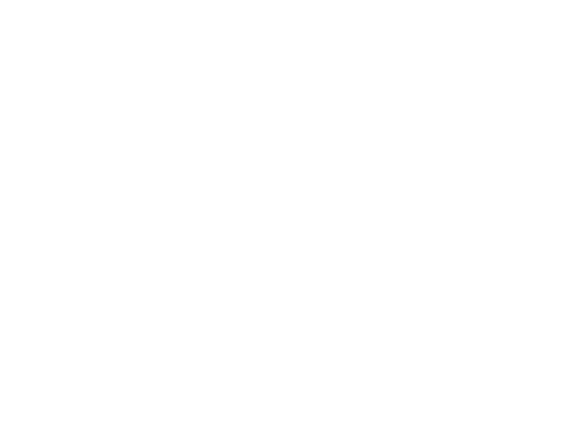

<IPython.core.display.Javascript object>


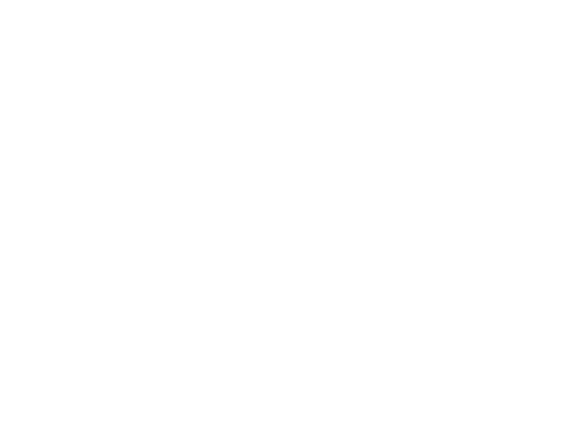

<IPython.core.display.Javascript object>


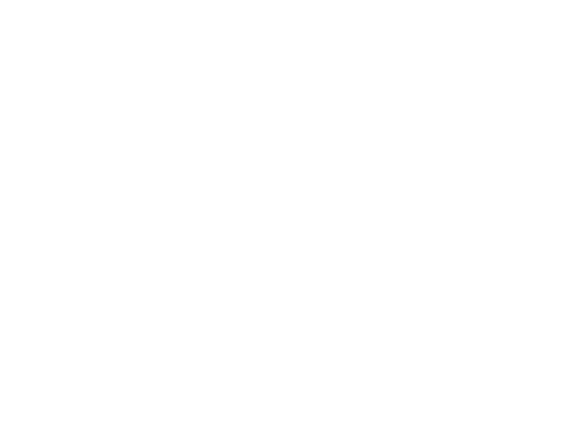

<IPython.core.display.Javascript object>


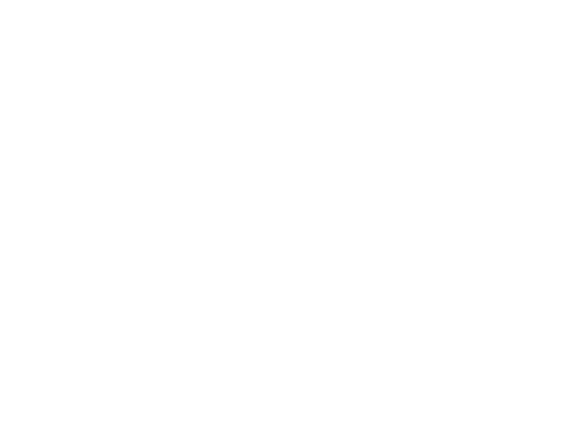

<IPython.core.display.Javascript object>


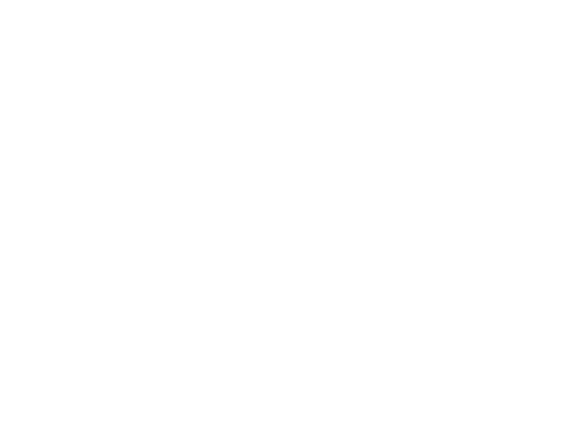

<IPython.core.display.Javascript object>


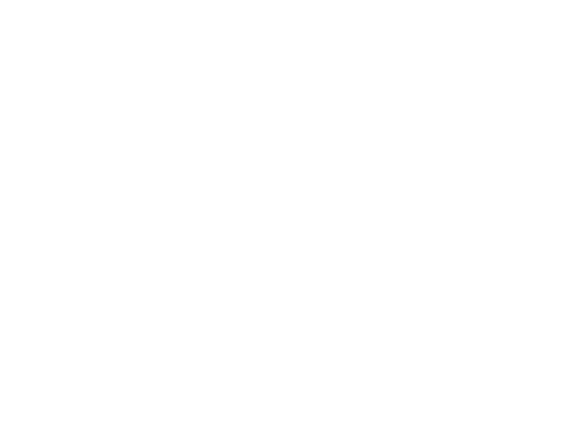

<IPython.core.display.Javascript object>


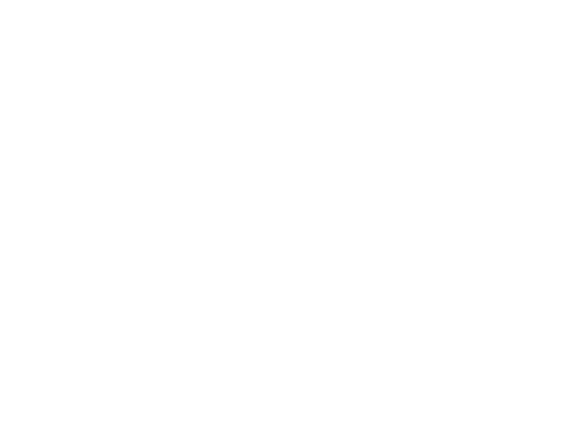

<IPython.core.display.Javascript object>


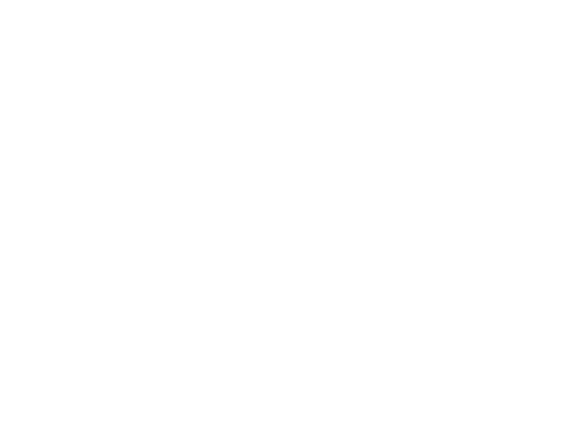

<IPython.core.display.Javascript object>


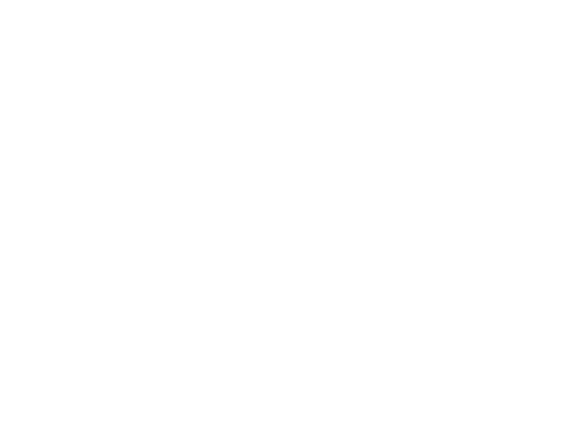

<IPython.core.display.Javascript object>


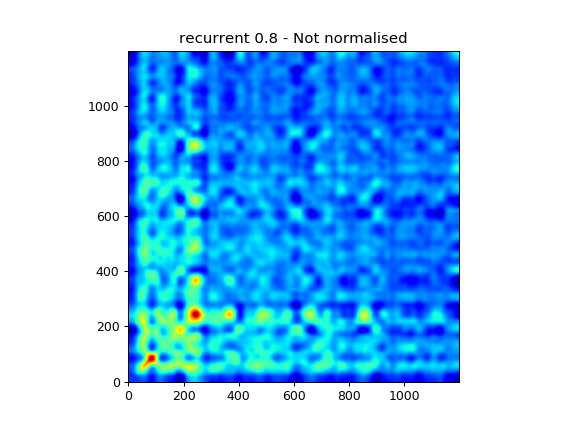

In [7]:
ctda_path = '/Users/s3182541/STSP/Decoding/data/sweep/ctdas/'
if not os.path.exists(ctda_path):
    os.mkdir(ctda_path)

for path, param, param_txt in zip(paths_prepared, params, params_txt):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    plt.close()

    plt.title(param_txt + " - Not normalised")
    plt.imshow(filtered, cmap='jet', origin='lower')
    plt.savefig(join(ctda_path, param + ".pdf"), dpi=300, format='pdf')

<IPython.core.display.Javascript object>


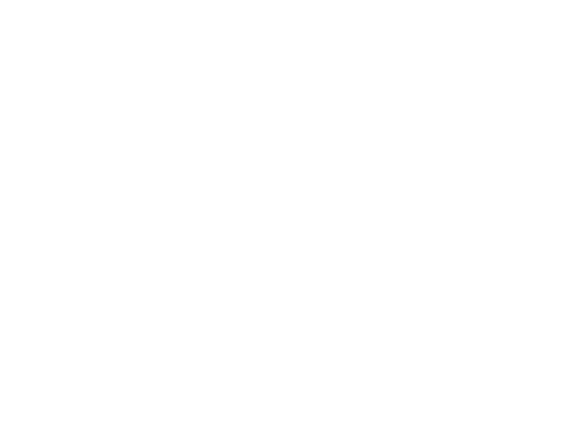

<IPython.core.display.Javascript object>


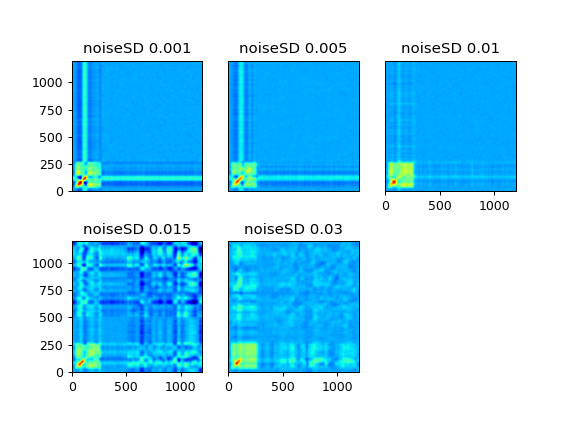

In [37]:
tups = [tup for tup in zip(paths_prepared, params_txt) if re.match(r".*noiseSD.*", tup[0])]
tups = [tups[i] for i in [0, 4, 3, 2, 1]]

vmin = 0
vmax = 0

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower')
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/cross-noiseSDs.pdf', dpi=300, format='pdf')

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/normalised-cross-noiseSDs.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


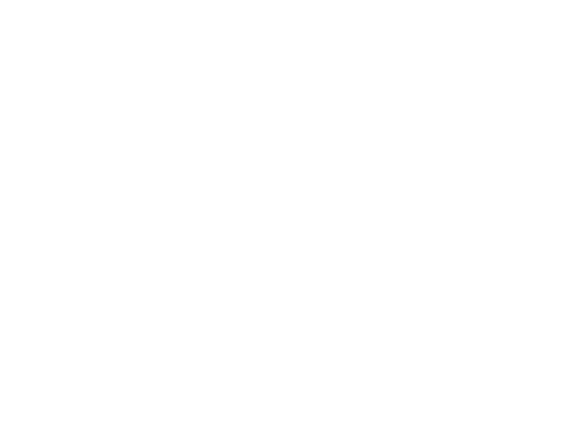

<IPython.core.display.Javascript object>


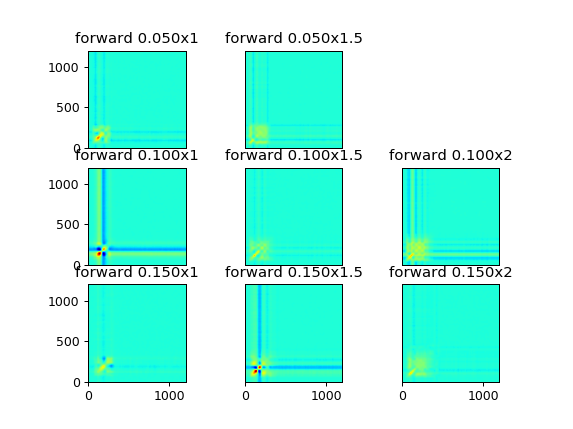

In [45]:
tups = [tup for tup in zip(paths_prepared, params_txt) if re.match(r".*forward.*", tup[0])]
tups = [tups[i] for i in [0, 7, 5, 3, 1, 2, 6, 4]]

vmin = 0
vmax = 0

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    if i >= 2:
        i = i + 1
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))

    ax = fig.add_subplot(330 + i + 1)
    ax.set_title(param_txt)
    if not i in [0, 3, 6]:
        plt.yticks([])
    if not i in [6, 7, 8]:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower')
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/cross-forwards.pdf', dpi=300, format='pdf')

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)

    if i >= 2:
        i = i + 1
    
    ax = fig.add_subplot(330 + i + 1)
    ax.set_title(param_txt)
    if not i in [0, 3, 6]:
        plt.yticks([])
    if not i in [6, 7, 8]:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/normalised-cross-forwards.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


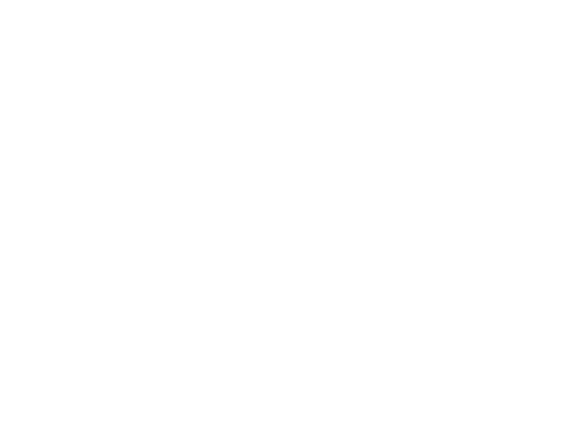

<IPython.core.display.Javascript object>


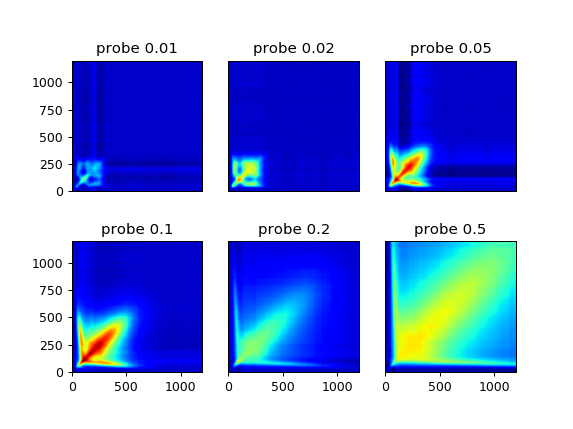

In [49]:
tups = [tup for tup in zip(paths_prepared, params_txt) if re.match(r".*probe.*", tup[0])]
tups = [tups[i] for i in [0, 4, 5, 1, 2, 3]]

vmin = 0
vmax = 0

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if not i in [0, 3]:
        plt.yticks([])
    if not i in [3, 4, 5]:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower')
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/cross-probes.pdf', dpi=300, format='pdf')

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if not i in [0, 3]:
        plt.yticks([])
    if not i in [3, 4, 5]:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/normalised-cross-probes.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


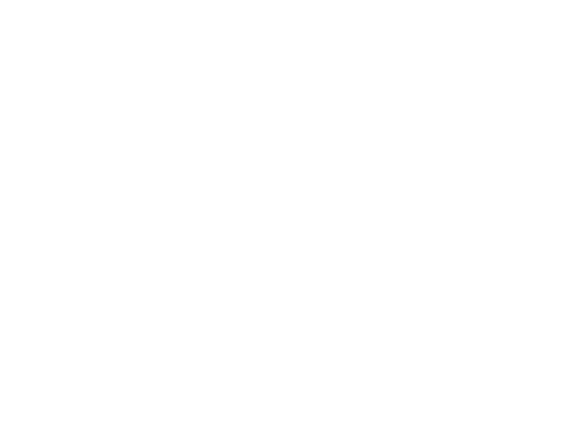

<IPython.core.display.Javascript object>


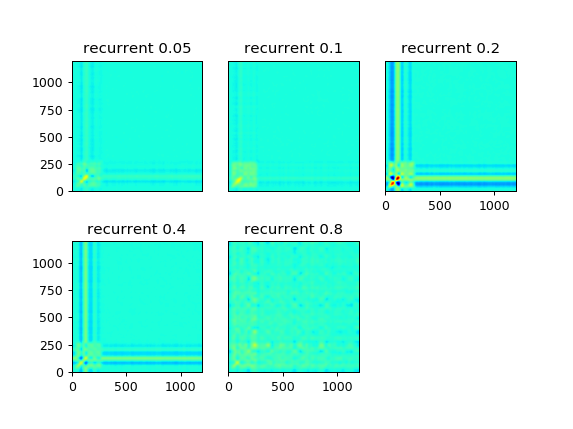

In [52]:
tups = [tup for tup in zip(paths_prepared, params_txt) if re.match(r".*recurrent.*", tup[0])]
tups = [tups[i] for i in [2, 3, 1, 0, 4]]

vmin = 0
vmax = 0

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)
    
    vmin = min(vmin, np.min(filtered))
    vmax = max(vmax, np.max(filtered))

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower')
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/cross-recurrents.pdf', dpi=300, format='pdf')

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    c_transformed = (c + c.T) / 2
    filtered = gaussian_filter(c_transformed, sigma=8)

    ax = fig.add_subplot(230 + i + 1)
    ax.set_title(param_txt)
    if i != 0 and i != 3:
        plt.yticks([])
    if i < 2:
        plt.xticks([])
    ax.imshow(filtered, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/normalised-cross-recurrents.pdf', dpi=300, format='pdf')

In [6]:
bin_width = np.pi / 6
angspace = np.arange(-np.pi, np.pi, bin_width)

plt.close()

for path, param_txt in zip(paths_prepared, params_txt):
    data = np.load(join(path, "data.npy"))
    angles = np.load(join(path, "angles.npy"))
    
    cos_amp, _ = wolff.similarity_p(data, angles, angspace, bin_width, 40)
    
    cos_amp = np.mean(cos_amp, 0)
    np.save(join(path, "cos_amp.npy"), cos_amp)
    
    plt.plot(cos_amp, label=param_txt)
    
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/decodabilities.pdf', dpi=300, format='pdf')
plt.show()

360


<IPython.core.display.Javascript object>


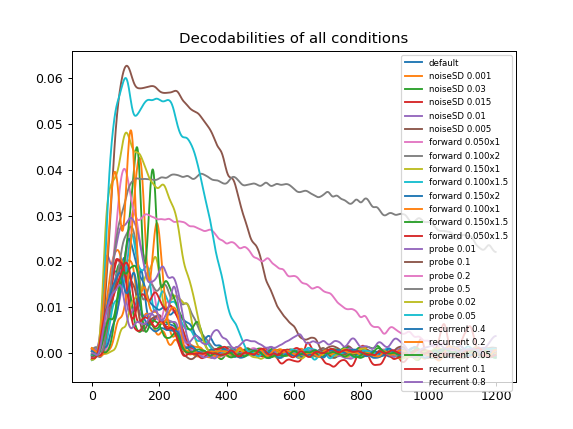

In [54]:
plt.close()

plt.title("Decodabilities of all conditions")

for path, param_txt in zip(paths_prepared, params_txt):
    cos_amp = np.load(join(path, "cos_amp.npy"))
    plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend(fontsize='x-small')
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/decodabilities.pdf', dpi=300, format='pdf')
plt.show()

<IPython.core.display.Javascript object>


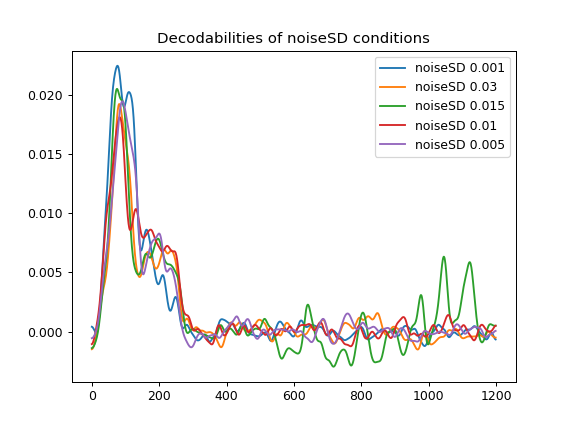

In [10]:
plt.close()

plt.title("Decodabilities of noiseSD conditions")

for path, param_txt in zip(paths_prepared, params_txt):
    if re.match(r".*noiseSD.*", path):
        cos_amp = np.load(join(path, "cos_amp.npy"))
        plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend()
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/noiseSDs.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


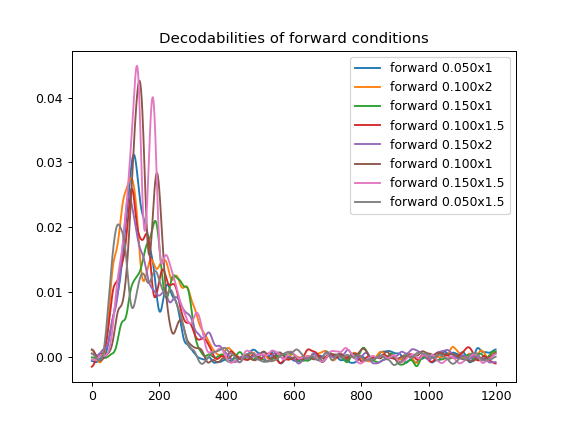

In [12]:
plt.close()

plt.title("Decodabilities of forward conditions")

for path, param_txt in zip(paths_prepared, params_txt):
    if re.match(r".*forward.*", path):
        cos_amp = np.load(join(path, "cos_amp.npy"))
        plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend()
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/forwards.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


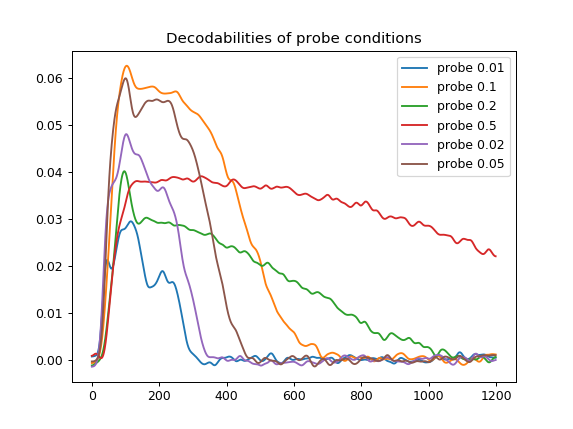

In [13]:
plt.close()

plt.title("Decodabilities of probe conditions")

for path, param_txt in zip(paths_prepared, params_txt):
    if re.match(r".*probe.*", path):
        cos_amp = np.load(join(path, "cos_amp.npy"))
        plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend()
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/probes.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


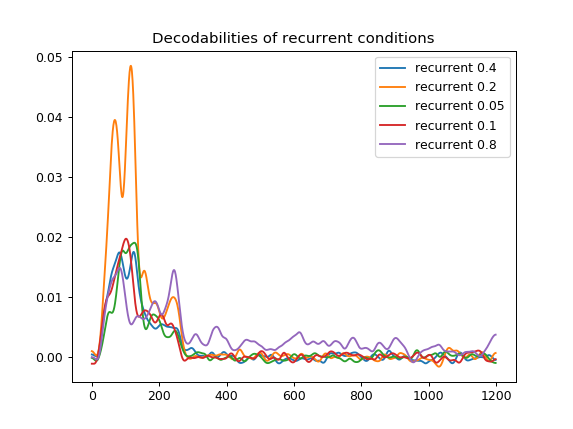

In [14]:
plt.close()

plt.title("Decodabilities of recurrent conditions")

for path, param_txt in zip(paths_prepared, params_txt):
    if re.match(r".*recurrent.*", path):
        cos_amp = np.load(join(path, "cos_amp.npy"))
        plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend()
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/recurrents.pdf', dpi=300, format='pdf')

<IPython.core.display.Javascript object>


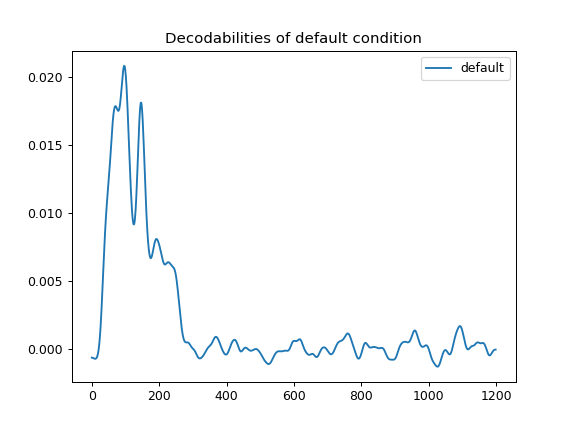

In [15]:
plt.close()

plt.title("Decodabilities of default condition")

for path, param_txt in zip(paths_prepared, params_txt):
    if re.match(r".*default.*", path):
        cos_amp = np.load(join(path, "cos_amp.npy"))
        plt.plot(gaussian_filter(cos_amp, sigma=8), label=param_txt)
    
plt.legend()
plt.savefig('/Users/s3182541/STSP/Decoding/data/sweep/default.pdf', dpi=300, format='pdf')